# Covid19 - Exploratory data analysis
**Table of contents:**
* Importing dependecies
* Basic data manipulation - grouping, aggregating etc.
* Model building

In [1]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# Getting all the files in "data" directory 
list_of_files = os.walk('./data/')
list_of_files = list(list_of_files)[0][2]

# For EDA purposes I am going to use only one country as a template
DIR = './data/'
COUNTRY = 'poland.csv'

In [3]:
dataset = pd.read_csv(DIR + COUNTRY)

In [4]:
dataset.head()

,Unnamed: 0,Date,Cases
0,0,2020-03-04,1
1,1,2020-03-05,1
2,2,2020-03-06,5
3,3,2020-03-07,5
4,4,2020-03-08,11


In [5]:
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset['Date'] = pd.to_datetime(dataset['Date'])

I am interested in prediciting not only *total cases* but also **new cases**, however dataset only contains *total cases* for each day. Luckly this provides enough information to **new cases**. We know that new cases is just the difference between day **n+1** and **n**. We can use a formula: ***NewCases*** = **TotalCases(n+1)** - **TotalCases(n)**. For the last row in the dataset NewCases is going to be undefined, becouse we don't have **TotalCases(n+1).**

In [6]:
# this loop implements formula from above
new_cases = []
for n in range(dataset.shape[0]):
    try:
        new_cases.append(dataset['Cases'][n+1] - dataset['Cases'][n])
    except KeyError:
        # new_cases.append(np.NaN) - would contain nan, so let's just pass
        pass

In [7]:
# Now let's drop last row becouse it contains a NaN
dataset.drop(dataset.tail(1).index, inplace=True)

In [8]:
dataset['New_cases'] = new_cases
dataset = dataset.rename(columns={'Cases' : 'Cummulative_cases'})
dataset.head()

,Date,Cummulative_cases,New_cases
0,2020-03-04,1,0
1,2020-03-05,1,4
2,2020-03-06,5,0
3,2020-03-07,5,6
4,2020-03-08,11,5


At the moment *date* column has a frequency of one day - in practice when we look at time series data we should be more concerned with *longer* periods of time such as weeks or months if not years in some cases. **Pandas** *groupby* is ideal for such case.

In [9]:
dataset = dataset.groupby(pd.Grouper(key='Date',freq='W-MON')).agg({'Cummulative_cases':'sum', 'New_cases':'sum'})
dataset = dataset.reset_index()
dataset.head()

,Date,Cummulative_cases,New_cases
0,2020-03-09,39,21
1,2020-03-16,569,216
2,2020-03-23,3188,663
3,2020-03-30,10117,1410
4,2020-04-06,23336,2537


In [10]:
# Spliting into two DataFrames
new_cases, cummulative_cases = dataset[['New_cases', 'Date']], dataset[['Cummulative_cases', 'Date']]
# Let index be data
new_cases = new_cases.set_index('Date')
cummulative_cases = cummulative_cases.set_index('Date')

new_cases.head()

,New_cases
Date,
2020-03-09,21
2020-03-16,216
2020-03-23,663
2020-03-30,1410
2020-04-06,2537


**Now our data in nicely organized :)**

**Let's move on to data visualiaztion.**

In [12]:
def plot(cummulative, new, save=False):
    # Function to plot both cummulative cases and new cases
    fig, ax = plt.subplots(2, 1, figsize=(12,12))

    ax[0].plot(cummulative, marker='o', color='red')
    ax[0].set_title('Cummulative cases')
    ax[1].plot(new, marker='o', color='red')
    ax[1].set_title('New cases')

    for i in range(2):
        for k in ['top', 'right']:
            ax[i].spines[k].set_visible(False)

        ax[i].spines['left'].set_color('black')
        ax[i].spines['bottom'].set_color('black')

        ax[i].grid(axis='y', linestyle='dashed')
        ax[i].xaxis.grid(False)
        
    if save:
        plt.savefig('sample_chart.pdf')
        
    plt.show()

**Curves represent sum of cummulative and new cases per week.**

Total cases is of course an exponential curve and over a long period of time it's change isn't very drastic. New cases on the other hand is much more unstable. WATCH https://www.youtube.com/watch?v=Kas0tIxDvrg&t=0s. 

**Forecasting time series**

While forecasting time series, there is one very important prerequisites, before fitting to a statistical model - **stationarity.**

**Stationarity** - Data is stationary when it's statistical properties (mean, standard deviation, variance) don't change over time. Good non-statistical method of testing statinarity is plotting and just looking and at **trend** and **seasonality.**

* **Trend** - long term tendency to increase or decrease (increasing sales over few years)
* **Seasonality** - short term tendency to increase or decrease (increasing sales during christmas)

**Knowing this let's plot the data**

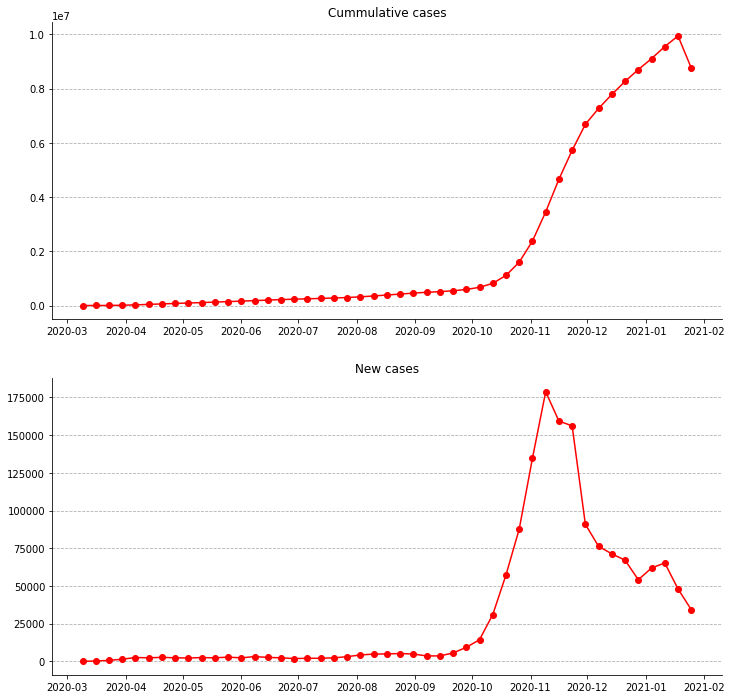

In [14]:
plot(cummulative_cases, new_cases)

**Cummulative cases** - Clear increasing trend, no visible seasonality.<br>
**New cases** - Hard to tell visually but I belive that from 2020-10 to 2021-02 is seasonal increase becouse during winter it is easier to get sick.<br>
**Statsmodels** provides a way to decompose data and plot trend and seasonality separately

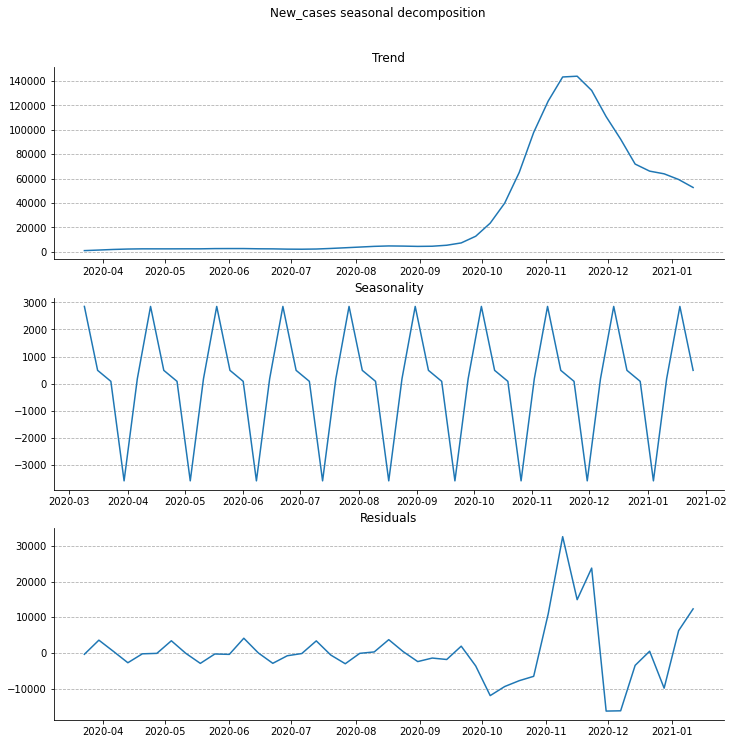

In [29]:
def decompose(data):
    # Using seasonal_decompose from statsmodels 
    decomposition = seasonal_decompose(data, period=5)
    trend = decomposition.trend
    seasonality = decomposition.seasonal
    residual = decomposition.resid
    # Plotting
    fig, ax = plt.subplots(3, 1, figsize=(12,12))
    ax[0].plot(trend)
    ax[0].set_title('Trend')
    ax[1].plot(seasonality)
    ax[1].set_title('Seasonality')
    ax[2].plot(residual)
    ax[2].set_title('Residuals')
    for i in range(3):
        for k in ['top', 'right']:
            ax[i].spines[k].set_visible(False)

        ax[i].spines['left'].set_color('black')
        ax[i].spines['bottom'].set_color('black')

        ax[i].grid(axis='y', linestyle='dashed')
        ax[i].xaxis.grid(False)
    fig.suptitle('{} seasonal decomposition'.format(data.columns[0]), y=0.95)
    plt.show()
    
decompose(new_cases)

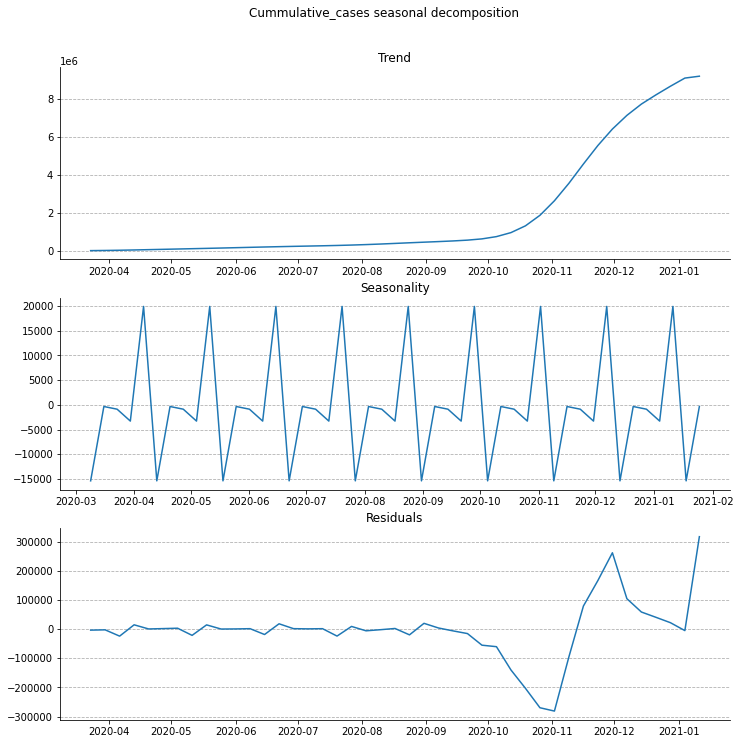

In [30]:
decompose(cummulative_cases)

**Now trend and seasonality are clearly visible.**<br>
In order to mathematicaly confirm what our visualizations are implying we can use **Dickey-fuller test.**<br>
**Dickey-fuller test** is probadly the most common statistical approach to test data stationarity. EXPLAIN DICKEY FULLER TEST HERE.

Results:
Test Statistic                 -4.299652
p-value                         0.000445
#Lags Used                      9.000000
Number of Observations Used    37.000000
dtype: float64
Critical value 1% 	 -3.6209175221605827
TTTT
Critical value 5% 	 -2.9435394610388332
TTTT
Critical value 10% 	 -2.6104002410518627
TTTT


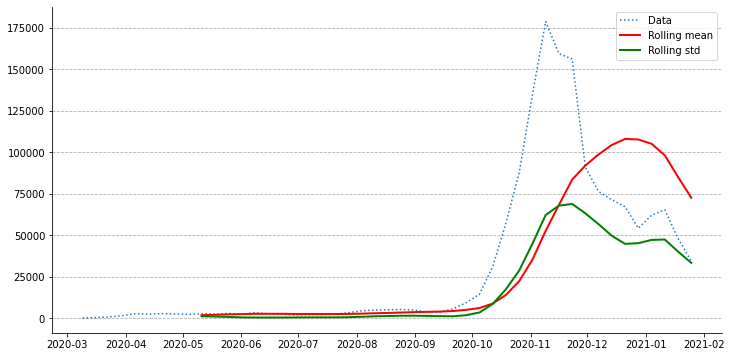

In [82]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(data):
    # Rolling mean and standard deviation
    rolling_mean = data.rolling(window=10).mean()
    rolling_std = data.rolling(window=10).std()
    # Dickey-fuller test
    print('Results:')
    test = adfuller(data)
    result = pd.Series(test[0:4], index=['Test Statistic', 
                                         'p-value', 
                                         '#Lags Used', 
                                         'Number of Observations Used'])
    print(result)
    for k,v in test[4].items():
        print('Critical value {} \t {}'.format(k, v))
#         if result.loc['Test Statistic'] < v:
#             print('TTTT')
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    plt.plot(data, ':', label='Data')
    plt.plot(rolling_mean, 'r', linewidth=2, label="Rolling mean")
    plt.plot(rolling_std, 'g', linewidth=2, label="Rolling std")
    for k in ['top', 'right']:
        ax.spines[k].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
    ax.grid(axis='y', linestyle='dashed')
    ax.xaxis.grid(False)
    ax.legend()
    
dickey_fuller(new_cases)

**Critical values are > Test Statistic, but rolling mean and rolling std are increasing, so data isn't stationary**

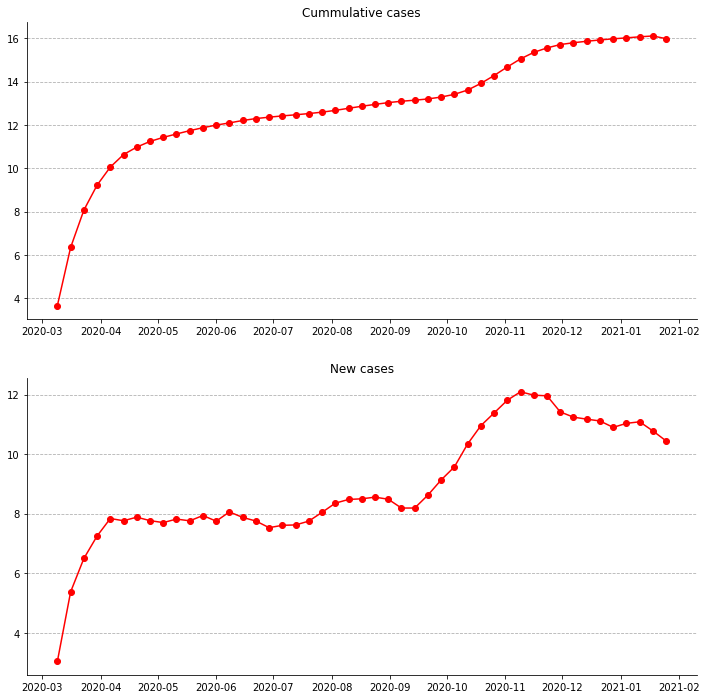

In [32]:
plot(np.log(cummulative_cases), np.log(new_cases))

In [ ]:
figure, ax = plt.subplots(1, 2, figsize=(15,5))

lag_plot(dataset['Cummulative_cases'], ax=ax[0], marker='x')
ax[0].set_title('Cummulative cases autocorrelation')
lag_plot(dataset['New_cases'], ax=ax[1], marker='x')
ax[1].set_title('New cases autocorrelation')

for i in range(2):
    for k in ['top', 'right']:
        ax[i].spines[k].set_visible(False)

    ax[i].spines['left'].set_color('black')
    ax[i].spines['bottom'].set_color('black')
    
    ax[i].grid(axis='y', linestyle='dashed')
    ax[i].xaxis.grid(False)
    
plt.savefig('autocorr.png')
plt.show()

In [ ]:
def train_test_split(dataset, split_size):
    # y has to be the last column
    size = int(split_size * dataset.shape[0])
    train, test = dataset[size:], dataset[:size]
    return train, test

In [ ]:
NC_train, NC_test = train_test_split(new_cases, 0.2)

In [ ]:
NC_train

In [ ]:
def rmse(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise Exception('Vectors have different dimiensions y_pred{} y_true{}'.format(y_true.shape, y_pred.shape))
    else:
        return np.sqrt(np.sum(np.square(y_pred - y_true))/len(y_true))

In [ ]:
rmse(np.array([-1, 1, 1]), np.array([0]))